## 1. Introduction

NASA Space Apps Challenge hackathon which was held in 2017 asked participants to predict the amount solar radiation using a set of measurable metoeorological conditions. The NASA HI-SEAS(Hawaii Space Exploration Analog and Simulation) site where provided the solar radiation dataset simulates a human settlement on Mars. 
<br>
The main power source in the settlement is obtained from a large solar array and battery bank. The prediction of solar radiaiton will help to decide when or where to deploy solar energy harvesting equipment.The can be found in Kaggle:https://www.kaggle.com/dronio/SolarEnergy 


## 2. About this dataset

The meteorlogical data from the dataset is from the HI-SEAS station from September through December 2016. The size of the dataset is 2.82 MB and 11 columns. It is consists of date and time and numerical formats. 

The units and formats of each dataset are:

* UNIX time_t date: seconds since Jan 1, 197

* Date: yyyy-mm-dd format

* Local time of day in hh:mm:ss: 24-hour format

* Solar radiation: watts per meter^2

* Temperature: degrees Fahrenheit

* Humidity: percent

* Barometric pressure: Hg

* Wind direction: degrees

* Wind speed: miles per hour

* Sunrise/sunset: Hawaii time


## 3. Data Exploration and Analysis

A feature engineering is conducted to get meaningful features from the date and time columns and remove unecessary features. Afterward I removed the missing values and outliers using an interquartile range. Linear Regression, Lasso, Random Forest and Extra Trees models are used to predict the solar radiation and the scores of mse and r-squared were utilized to evaluate models. 

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from yellowbrick.regressor import ResidualsPlot, PredictionError

/Users/irenecho/work/venv/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('SolarPrediction.csv')
# for i in ['Time','TimeSunRise','TimeSunSet']:
#     df[i] = pd.to_timedelta(df[i]).dt.total_seconds().astype(float)

In [3]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


## Feature Engineering

In [4]:
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
df['UNIXTime'] =  pd.to_datetime(df['UNIXTime'], unit='s')
df['DayofYear'] =pd.DatetimeIndex(df['UNIXTime']).dayofyear
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S')
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S')
df['DayLength(s)'] = df['TimeSunSet'].dt.hour*60*60 \
                           + df['TimeSunSet'].dt.minute*60 \
                           + df['TimeSunSet'].dt.second \
                           - df['TimeSunRise'].dt.hour*60*60 \
                           - df['TimeSunRise'].dt.minute*60 \
                           - df['TimeSunRise'].dt.second
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'], axis=1, inplace=True)

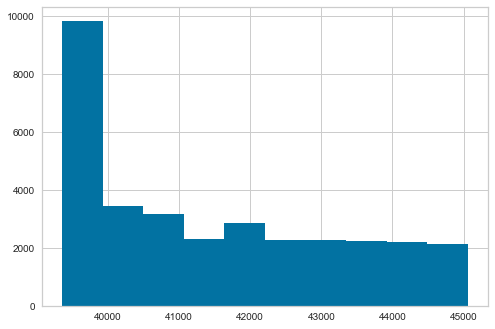

In [5]:
df['DayLength(s)'].hist()

In [6]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,DayofYear,DayLength(s)
0,1.21,48,30.46,59,177.39,5.62,274,43200
1,1.21,48,30.46,58,176.78,3.37,274,43200
2,1.23,48,30.46,57,158.75,3.37,274,43200
3,1.21,48,30.46,60,137.71,3.37,274,43200
4,1.17,48,30.46,62,104.95,5.62,274,43200


## Find and remove outliers

In [7]:
len(df)

32686

In [8]:
df.dropna(inplace=True)
len(df)

32686

In [9]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,DayofYear,DayLength(s)
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,305.187328,41433.032491
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,39.207761,1795.873502
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,1.000000,39360.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,277.000000,39720.000000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,306.000000,41040.000000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,334.000000,42900.000000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,366.000000,45060.000000


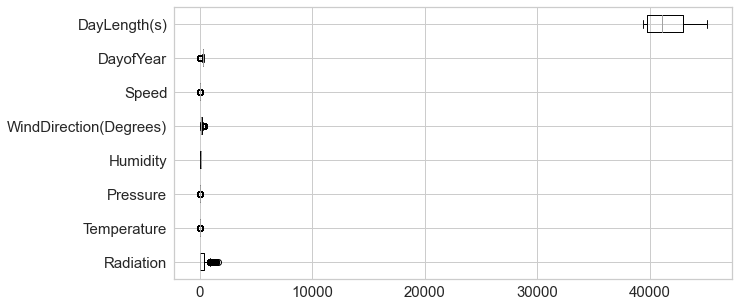

In [10]:
_=df.boxplot(grid=True, vert=False,fontsize=15,figsize=(10,5))

27502

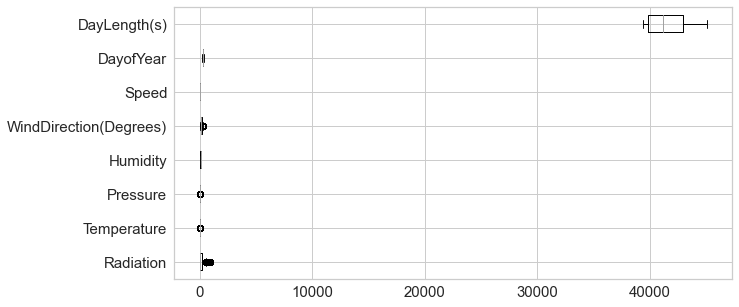

In [11]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =Q3 - Q1
dfno =  df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]
_ =dfno.boxplot(grid=True, vert=False,fontsize=15, figsize=(10,5))
len(dfno)

In [12]:
df =dfno

## Correlation Matrix

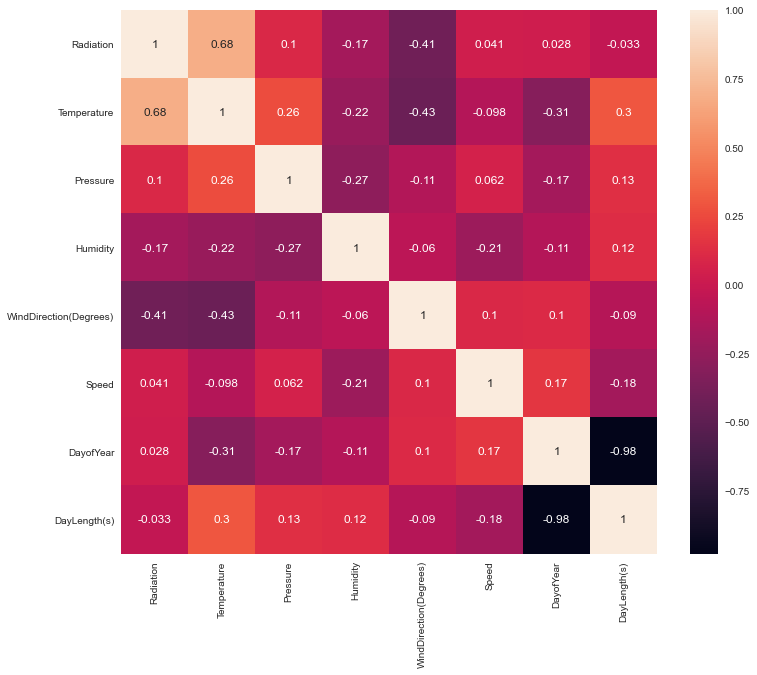

In [13]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True,cmap ='Blues')

In [14]:
X = df.drop(['Radiation','DayofYear'],axis=1)

In [15]:
y = df.Radiation
y = y.ravel()

In [16]:
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)

In [17]:
X_train.min(),X_train.min()

(0.0, 0.0)

In [18]:
X_train= preprocessing.scale(X_train)
X_test= preprocessing.scale(X_test)

## Linear Regression
### 1) Fit a linear regression model

In [20]:
def sklearnfit(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    mse_test = metrics.mean_squared_error(y_test, pred_test)
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    r2 = metrics.r2_score(y_test, pred_test)
    print(f'MSE_Train:{round(mse_train,4)}, MSE_Test:{round(mse_test,4)}, R2:{round(r2,4)}')
    return model
model1 = sklearnfit(LinearRegression(),X_train, X_test, y_train, y_test)

MSE_Train:27115.6872, MSE_Test:27140.5836, R2:0.5637


###  2) Evaluate a model

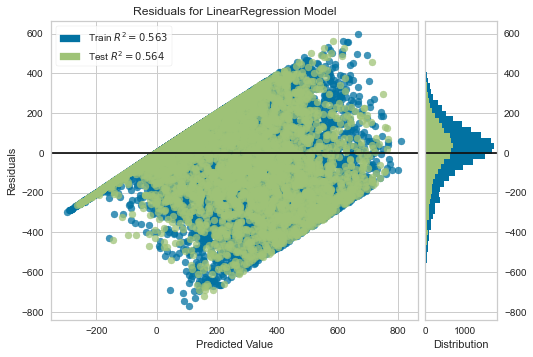

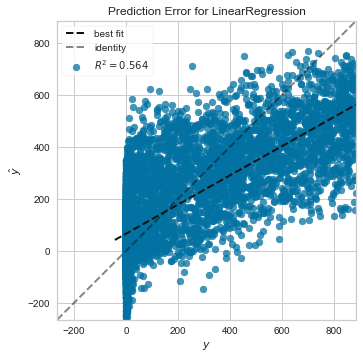

In [21]:
def drawplot(model):
    plots=[ResidualsPlot(model),PredictionError(model)]
    for i in plots:
        i.fit(X_train, y_train)
        i.score(X_test, y_test)
        _=i.show()
drawplot(model1)

### 3) Statistical modeling

In [22]:
def olsfunc(X_train,y_train):
    X_ols = sm.add_constant(X_train)
    model_ols = sm.OLS(y_train,X_ols)
    res = model_ols.fit()
    return res, res.summary()
statsmodel, statsmodelsummary= olsfunc(X_train,y_train)
statsmodelsummary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     4132.
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:59:27   Log-Likelihood:            -1.2557e+05
No. Observations:               19251   AIC:                         2.512e+05
Df Residuals:                   19244   BIC:                         2.512e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.2158      1.187    125.705      0.000     146.889     151.543
x1           158.9387      1.637     97.082      0.000     155.730     162.148
x2            -7.0710      1.269     -5.570      0.000      -9.559      -4.583
x3            -7.6790      1.633     -4.702      0.000     -10.880      -4.478
x4          -101.4192      4.268    -23.763      0.000    -109.785     -93.054
x5            23.5560      1.261     18.682      0.000      21.085      26.028
x6           -69.7509      3.995    -17.459      0.000     -77.582     -61.920
==============================================================================
Omnibus:                     1916.227   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3046.026
Skew:                           0.732   Prob(JB):                         0.00
Kurtosis:                       4.285   Cond. No.                         7.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
df1 = pd.DataFrame(abs(statsmodel.params[1:]), X.columns,columns=['Coefficient'])
df1.sort_values(by = 'Coefficient',ascending=False).head(10)

,Coefficient
Temperature,158.938740
WindDirection(Degrees),101.419237
DayLength(s),69.750905
Speed,23.556036
Humidity,7.679038
Pressure,7.070972


In [26]:
X.columns

Index(['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)',
       'Speed', 'DayLength(s)'],
      dtype='object')

## Lasso regression

In [42]:
X = df.drop(['Radiation'],axis=1)
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)
X_train= preprocessing.scale(X_train)
X_test= preprocessing.scale(X_test)
lasso_model = Lasso(random_state=123)
model_lasso = sklearnfit(lasso_model,X_train, X_test, y_train, y_test)


MSE_Train:27146.2822, MSE_Test:27257.7288, R2:0.5618


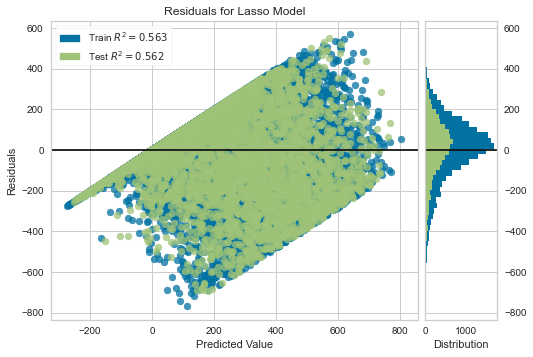

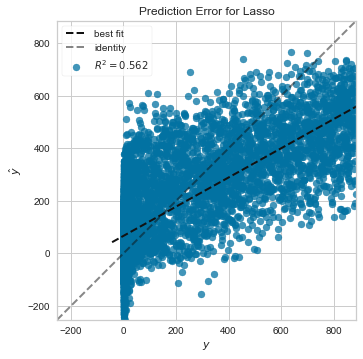

In [43]:
drawplot(model_lasso)

## RandomForest 

In [32]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(['Radiation'],axis=1)
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)
rfmodel = RandomForestRegressor(n_estimators = 100)
rfmodel_fit = sklearnfit(rfmodel,X_train, X_test, y_train, y_test)

MSE_Train:1366.426, MSE_Test:9709.6452, R2:0.8439


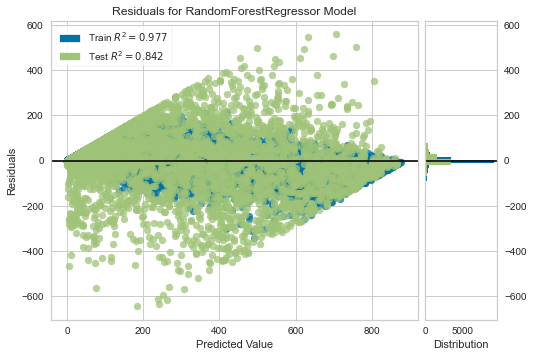

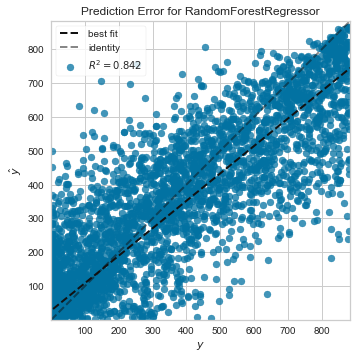

In [41]:
drawplot(rfmodel)

7


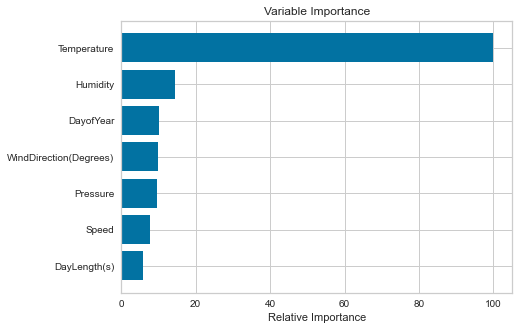

In [35]:
feature_importance = rfmodel.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## ExtraTrees

In [49]:
from sklearn.ensemble import ExtraTreesRegressor
extra_model = ExtraTreesRegressor(random_state=123)
extramodel_fit = sklearnfit(extra_model,X_train, X_test, y_train, y_test)

MSE_Train:0.5682, MSE_Test:9507.7716, R2:0.8472


In [43]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [123],
}
extra_cv= GridSearchCV(extra_model,param_grid,cv=5)
extra_cv.fit(X,y)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=123),
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'n_estimators': [320, 330, 340],
                         'random_state': [123]})

In [44]:
print("Best Score:" + str(extra_cv.best_score_))
print("Best Parameters: " + str(extra_cv.best_params_))

Best Score:0.5478514824530853
Best Parameters: {'max_depth': 8, 'n_estimators': 320, 'random_state': 123}


In [47]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_accuracy = evaluate(extra_cv, X_test, y_test)

Model Performance
Average Error: 164.0553 degrees.
Accuracy = -2716.97%.


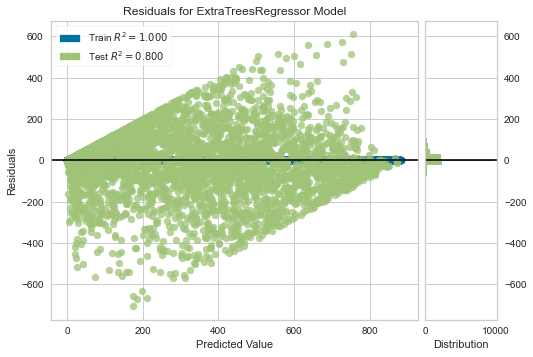

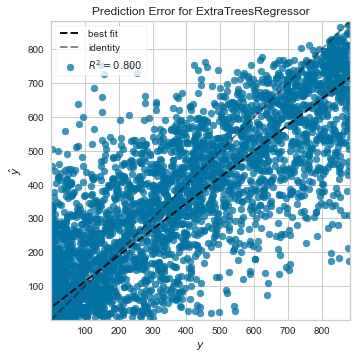

In [39]:
drawplot(extra_model)

7


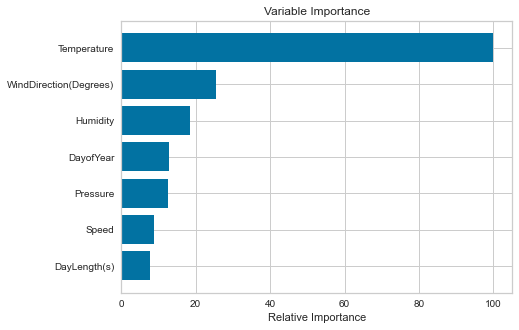

In [48]:
feature_importance = extra_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Model Summary and future study


For predicting the amount of solar radiation, I recommend using Extra Trees which was the least MSE values and the biggest R squared value among the other models. According to the model summary of extra trees model, temperature, wind direction and humidity were the top three dependent variables which can attribute to radiation. The random forest model had the same results and linear regression had high coefficients of temperature and wind direction and a positive value of humidity. Therefore, HI-SEAS team can consider these three main features when they decide to install additional panels. 
<br>
However, extra trees model had a risk of overfitting. For the further research, we can consider different machine learning models or hyperparameter tuning to reduce the overfitting. 
